<a href="https://colab.research.google.com/github/aashmore/CV/blob/main/Anthony/L_CB%20layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

See https://github.com/PhilipVinc/Lectures/tree/main and https://github.com/netket/netket/tree/master/Examples for more examples.

# Ground State Variational Searches with NetKet

We start by studying the Ising model in 2d:
$$H=\Gamma \sum_i \sigma_i^{(x)} + V \sum_{i,j} \sigma_i^{(z)}\sigma_{j}^{(z)}.$$
We assume periodic boundary conditions and count lattice sites start from zero such that $i,j=0,1,\ldots,L-1$ and $i=L\equiv0$.

## Installing NetKet

On Google Colab, use the following command to install the required packages.

In [ ]:
!pip install --upgrade matplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of jax[cuda] to determine which version is compatible with other requirements. This could take a while.


In [ ]:
!pip install --upgrade netket

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.9/485.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 34.2 MB/s eta 0:00:00


We also want to make sure that Jax is running on the CPU. It benefits from a GPU only for large numbers of spins.

In [ ]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

Check the install was successful and print the version.

In [ ]:
import netket as nk
print(f"NetKet version: {nk.__version__}")

NetKet version: 3.8


## Defining the Hamiltonian

Start by defining the Hamiltonian of the system. We first define the degrees of freedom we are dealing with by specifying the Hilbert space of the problem. We start with an example of $N\times N$ spins on a lattice.

Number of edges in graph: 32
Number of nodes in graph: 16
List of edges in graph: [(3, 7), (12, 13), (8, 9), (8, 12), (2, 14), (13, 14), (4, 5), (5, 6), (4, 8), (12, 15), (5, 9), (14, 15), (3, 15), (8, 11), (0, 1), (9, 10), (1, 2), (0, 4), (9, 13), (10, 11), (1, 5), (10, 14), (6, 7), (6, 10), (4, 7), (0, 3), (0, 12), (2, 3), (1, 13), (2, 6), (11, 15), (7, 11)]


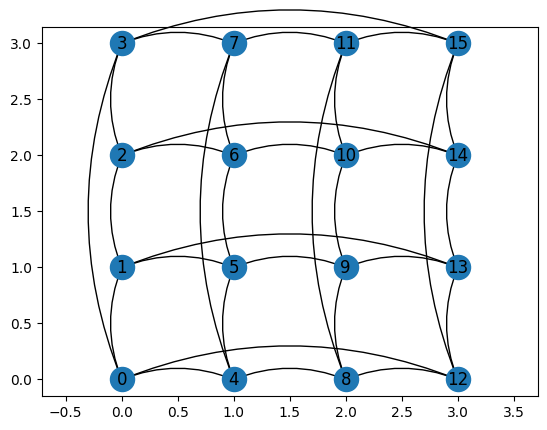

In [ ]:
# size of lattice
L = 4

graph = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)

print("Number of edges in graph:",graph.n_edges)
print("Number of nodes in graph:",graph.n_nodes)

print("List of edges in graph:",graph.edges())

graph.draw()

# number of nodes in graph
N = graph.n_nodes

hi = nk.hilbert.Spin(s=1/2)**(N)

Now important Jax and generate two random states.

In [ ]:
import jax

hi.random_state(key=jax.random.PRNGKey(0), size=1)

Array([[-1.,  1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,  1.,  1., -1.,
        -1.,  1., -1.]], dtype=float32)

Next we specify the Hamiltonian. We use NetKet's LocalOperator function, which is the sum of arbitrary "$k$-local" operators. In our case, $\sigma_i^{(x)}$ is a 1-local operator, and $\sigma_i^{(z)}\sigma_{j}^{(z)}$ is a 2-local operator. Start by importing the Pauli matrices.

In [ ]:
from netket.operator.spin import sigmax, sigmaz

Now add the 2-local interaction term. NetKet automatically sees products of local operators as tensor products.

**WHAT DOES "%N" DO IN THIS?** It is mod N, so it wraps around at the end of the loop.

Print edges of graph - these are non-repeated so can be summed over for nearest neighbour interactions.

[(i,j) for (i,j) in graph.edges()] prints the edges of the graph.

In [ ]:
J = 1.

H = sum([-J*sigmax(hilbert=hi, site=i) for i in range(N)])

h = 1.
H = H + sum([-h*sigmaz(hilbert=hi, site=i)*sigmaz(hilbert=hi, site=j) for (i,j) in graph.edges()])

## Exact diagonalisation

We can start by trying exact diagonalisation. This works by converting the Hamiltonian operator in a sparse matrix of size $2^{N^2} \times 2^{N^2} = 1024 \times 1024$.

In [ ]:
sp_h = H.to_sparse()

sp_h.shape

(65536, 65536)

This is just a standard scipy sparse matrix, so we can use any (sparse) matrix diagonalisation routine to find the eigensystem. For example, we can find the two lowest eigenstates via:

In [ ]:
# from scipy.sparse.linalg import eigsh

# eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")

eig_vals = nk.exact.lanczos_ed(H, k=6)

print("Eigenvalues with sparse solver:", eig_vals)

print("Energy per site:", eig_vals / (L**2))

E_gs = eig_vals[0]

Eigenvalues with sparse solver: [-34.01059755 -34.010597   -26.72506198 -26.72419744 -26.48006393
 -26.47987742]
Energy per site: [-2.12566235 -2.12566231 -1.67031637 -1.67026234 -1.655004   -1.65499234]


## Neural network quantum state

In [ ]:
# numerical operations in the model should always use jax.numpy
# instead of numpy because jax supports computing derivatives.
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax

# we refer to `flax.linen` as `nn`. It's a repository of
# layers, initializers and nonlinear functions.
import flax.linen as nn

In [ ]:
# A Flax model must be a class subclassing `nn.Module`
# The most compact way to define the model is this.
# The __call__(self, x) function should take as
# input a batch of states x.shape = (n_samples, L)
# and should return a vector of n_samples log-amplitudes
class FFN(nn.Module):

    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole
    # flax module.
    alpha : int = 1

    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        # bug in complex layers in flax has been fixed
        dense = nn.Dense(features=self.alpha * x.shape[-1], kernel_init=nn.initializers.normal(stddev=0.01))

        # we apply the dense layer to the input
        y = dense(x)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)

        # sum the output
        return jnp.sum(y, axis=-1)

# Create an instance of the model.
model = FFN(alpha=3)

# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

vstate.n_parameters

/usr/local/lib/python3.10/dist-packages/netket/vqs/mc/mc_state/state.py:58: UserWarning: n_samples=1000 (1000 per MPI rank) does not divide n_chains=16, increased to 1008 (1008 per MPI rank)
  warnings.warn(


12480

In [ ]:
# Then we create an optimiser from the standard library.
# You can also use optax.
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

# build the optimisation driver
# Notice the use of Stochastic Reconfiguration which considerably improves the optimisation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=nk.optimizer.SR(diag_shift=0.1))

log = nk.logging.RuntimeLog()

gs.run(n_iter=600, out=log)

ffn_energy = vstate.expect(H)

error = abs((ffn_energy.mean - E_gs)/E_gs)

print("Optimised energy and relative error:", ffn_energy,error)

 27%|██▋       | 161/600 [03:10<08:02,  1.10s/it, Energy=-64.10 ± 0.10 [σ²=10.47, R̂=1.0069]]

Text(0, 0.5, 'Energy')

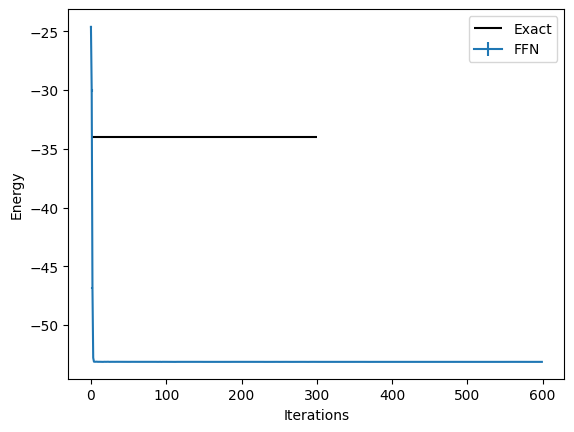

In [ ]:
data_FFN = log.data

from matplotlib import pyplot as plt

plt.errorbar(data_FFN["Energy"].iters, data_FFN["Energy"].Mean, yerr=data_FFN["Energy"].Sigma, label="FFN")
plt.hlines([E_gs], xmin=0, xmax=300, color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')

## Translation symmetry

In order to enforce spatial symmetries we can use some built-in functionalities of NetKet, in conjunction with equivariant layers.

The first step is to construct explicitly a graph that contains the edges of our interactions, in this case this is a simple chain with periodic boundaries. NetKet has builtin several symmetry groups that can be used to target specific spatial symmetries. In this case for example after constructing the graph we can also print its translation group.

In [ ]:
print(graph.translation_group())

PermutationGroup(elems=[Id(), Translation([0, 1]), Translation([0, 2]), Translation([0, 3]), Translation([0, 4]), Translation([1, 0]), Translation([1, 1]), Translation([1, 2]), Translation([1, 3]), Translation([1, 4]), Translation([2, 0]), Translation([2, 1]), Translation([2, 2]), Translation([2, 3]), Translation([2, 4]), Translation([3, 0]), Translation([3, 1]), Translation([3, 2]), Translation([3, 3]), Translation([3, 4]), Translation([4, 0]), Translation([4, 1]), Translation([4, 2]), Translation([4, 3]), Translation([4, 4])], degree=25)


Graphs are in general quite handy when defining hamiltonian terms on their edges. For example we can define our Hamiltonian as
```
Gamma=-1
H = sum([Gamma*sigmax(hi,i) for i in range(N)])

V=-1
H += sum([V*sigmaz(hi,i)*sigmaz(hi,j) for (i,j) in graph.edges()])
```



We now write a model with an invariant transformation given by the translation group. Notice that we now use NetKet's own nn module, instead of Flax, since it contains several additions.

In [ ]:
class SymmModel(nn.Module):
    alpha: int = 1

    @nn.compact
    def __call__(self, x):

        x = x.reshape(-1, 1, x.shape[-1])

        x = nk.nn.DenseSymm(symmetries=graph.translation_group(),
                           features=self.alpha,
                           kernel_init=nn.initializers.normal(stddev=0.01))(x)
        x = nn.relu(x)

        # sum the output
        return jnp.sum(x,axis=(-1,-2))


sampler = nk.sampler.MetropolisLocal(hi)

# Let us define a model with 3 features per symmetry
model=SymmModel(alpha=3)

vstate = nk.vqs.MCState(sampler, model, n_samples=10000)

vstate.n_parameters

78

As it can be seen, the number of parameters of this model is greatly reduced, because of the symmetries that impose constraints on the weights of the dense layers. We can now optimize the model, using a few more optimization steps than before.

In [ ]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))

log=nk.logging.RuntimeLog()
gs.run(n_iter=600,out=log)

symm_energy=vstate.expect(H)
error=abs((symm_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",symm_energy,error)

100%|██████████████████████████| 600/600 [04:10<00:00,  2.40it/s, Energy=-53.141562 ± 0.000048 [σ²=0.000019, R̂=1.0009]]


Optimized energy and relative error:  -53.141543 ± 0.000046 [σ²=0.000020, R̂=1.0007] 0.5624995424452878


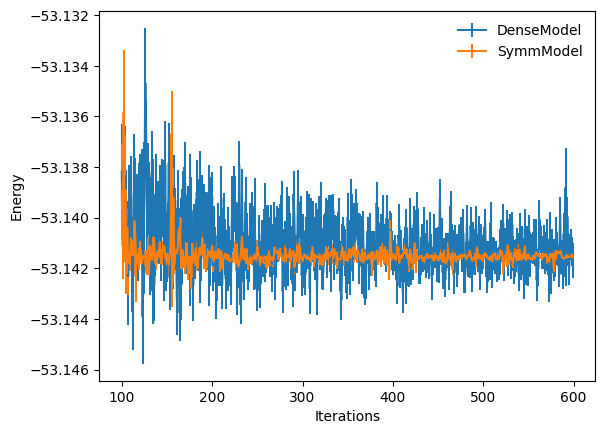

In [ ]:
plt.errorbar(data_FFN["Energy"].iters[100:],data_FFN["Energy"].Mean[100:],yerr=data_FFN["Energy"].Sigma[100:],label="DenseModel")
plt.errorbar(log.data["Energy"].iters[100:],log.data["Energy"].Mean[100:],yerr=log.data["Energy"].Sigma[100:],label="SymmModel")

#plt.axhline(y=eig_vals[0], xmin=0, xmax=log.data["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend(frameon=False)

## Other properties

Once the model has been optimized, we can of course measure also other observables that are not the energy. For example, we could decide to measure the value of the nearest-neighbor $\sigma^{(x)}-\sigma^{(x)}$ correlator. Notice that since correlators do not enjoy the zero-variance principle as the Hamiltonian instead does, it is important to use a larger number of samples to have a sufficiently low error bar on their measurement.

In [ ]:
corr = sum([sigmax(hi,i)*sigmax(hi,j) for (i,j) in graph.edges()])

vstate.n_samples=400000

vstate.expect(corr)

10.871 ± 0.018 [σ²=31.497, R̂=1.0002]

And we can further compare this to the exact diagonalisation result.

In [ ]:
psi = eig_vecs[:, 0]
exact_corr=psi@(corr.to_sparse()@psi)
print(exact_corr)

10.852248713127803
